# <u>S</u>tabilizer <u>S</u>ub<u>S</u>pace (S3) Projections

A library providing the necessary functionality to perform stabilizer subspace projections over systems of Pauli 
operators.

This facilitates implementations of qubit reduction techniques such as [*tapering*](https://arxiv.org/abs/1701.08213) and [*Contextual-Subspace VQE*](https://doi.org/10.22331/q-2021-05-14-456), both of which are demonstrated here.

In [1]:
from qondense.tapering import tapering
from qondense.cs_vqe import cs_vqe
import qondense.utils.qonversion_tools as qonvert
from qondense.utils.operator_toolkit import exact_gs_energy, plot_ground_state_amplitudes

import numpy as np
import openfermion as of
import openfermionpyscf as ofpyscf
from itertools import combinations
import json

First of all, we construct our molecular Hamiltonian:

Number of qubits: 14
The Hartree-Fock state is |11111111110000>
Amplitude histogram for the ground state of the full system:


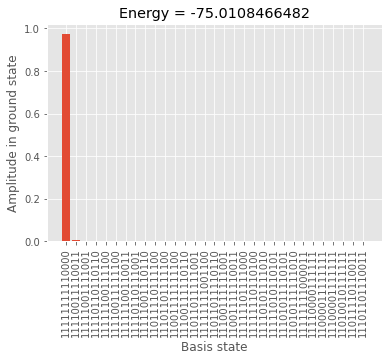

In [25]:
# Set molecule parameters

#geometry = [('Be',(0,0,0))]

geometry = [
    ("O",(0,0,0)),
    ("H",(0.952519,0,0)),
    ("H",(-0.246530058,0.9200627021,0))
    ]

# ...and one for which it does not.
#geometry=[
#    ('H', (0.0,0.0,0.0)),
#    ('H', (2.45366053071732,0.0,0.0)),
#    ('H', (2.45366053071732,2.45366053071732,0.0)),
#    ('H', (0.0,2.45366053071732,0.0))
#     ] 

# larger molecules...
# acetonitrile 36-qubits
#geometry = [
#    ("C",(0.0000000,0.0000000,-1.1949070)),
#    ("C",(0.0000000,0.0000000,0.2914180)),
#    ("N",(0.0000000,0.0000000,1.4456670)),
#    ("H",(0.0000000,1.0230490,-1.5662460)),
#    ("H",(0.8859860,-0.5115240,-1.5662460)),
#    ("H",(-0.8859860,-0.5115240,-1.5662460))
#    ]

## acetaldehyde 38-qubits
#geometry = [
#    ("C",(0.0000000,0.4826850,0.0000000)),
#    ("C",(-0.9789880,-0.7332270,0.0000000)),
#    ("O",(1.2580560,0.3871360,0.0000000)),
#    ("H",(-0.5192630,1.4800570,0.0000000)),
#    ("H",(-0.4184910,-1.6828310,0.0000000)),
#    ("H",(-1.6263830,-0.6955340,0.8935390)),
#    ("H",(-1.6263830,-0.6955340,-0.8935390))
#    ]

## isopropyl alcohol
#geometry = [
#    ("C",(-0.0010950,0.0578840,0.3635920)),
#    ("C",(-1.2013060,-0.8054790,-0.1047880)),
#    ("C",(1.3455540,-0.5533270,-0.0859750)),
#    ("O",(-0.0579290,1.3886050,-0.1773610)),
#    ("H",(-0.0150570,0.0957830,1.4621500)),
#    ("H",(-2.1389820,-0.3683150,0.2269260)),
#    ("H",(-1.2183220,-0.8752060,-1.1879640)),
#    ("H",(-1.1277480,-1.8069970,0.3069340)),
#    ("H",(2.1677070,0.0694700,0.2525950)),
#    ("H",(1.4674160,-1.5485010,0.3300660)),
#    ("H",(1.3862080,-0.6197140,-1.1687070)),
#    ("H",(-0.9167140,1.7501750,0.1599160))
#    ]

basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
#molecule.load()

# Run pyscf.
molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=0,run_cisd=0,run_ccsd=0,run_fci=0)

n_electrons = molecule.n_electrons
n_qubits    = 2*molecule.n_orbitals
hf_state    = [1 for i in range(n_electrons)]+[0 for i in range(n_qubits-n_electrons)]
hf_string   = ''.join([str(i) for i in hf_state])
print(f'Number of qubits: {n_qubits}')
print(f'The Hartree-Fock state is |{hf_string}>')


ham_fermionic = of.get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_jw = of.jordan_wigner(ham_fermionic)

ham_dict = qonvert.QubitOperator_to_dict(ham_jw, n_qubits)

#print('Jordan-Wigner Hamiltonian:\n\n', ham_dict)
print('Amplitude histogram for the ground state of the full system:')
amps, true_gs = plot_ground_state_amplitudes(ham_dict, n_qubits, return_amps=True)

Perform qubit tapering to reduce the number of necessary qubits:

In [26]:
taper_hamiltonian = tapering(hamiltonian=ham_dict, 
                               ref_state=hf_state)
ham_tap = taper_hamiltonian.taper_it()
tap_gs_energy, tap_gs = exact_gs_energy(ham_tap._dict)
print(taper_hamiltonian.symmetry_sec)
print(f'In the sector {taper_hamiltonian.symmetry_sec}, we find the ground state energy to be {tap_gs_energy}.')
print(f'The absolute error is {tap_gs_energy-true_gs}.')

[-1, -1, 1, 1]
In the sector [-1, -1, 1, 1], we find the ground state energy to be -75.01084664817068.
The absolute error is 1.1368683772161603e-13.


Build CS-VQE model with legacy code for comparison:

In [18]:
from qondense.utils.cs_vqe_tools_legacy import csvqe_approximations_heuristic, quasi_model, greedy_dfs

ham = ham_tap._dict
#terms_noncon = greedy_dfs(ham, cutoff=5)[-1]
terms_noncon = [op for op in ham if set(op) in [{'I'},{'Z'},{'I','Z'}]]
ham_noncon = {op:ham[op] for op in terms_noncon}
n_qubits = ham_tap.n_qbits

csvqe = csvqe_approximations_heuristic(ham, 
                                       ham_noncon, 
                                       n_qubits, 
                                       tap_gs_energy)

print('CS-VQE errors:', list(zip(range(n_qubits+1), csvqe[2])), '\n')
print('chosen order:', csvqe[3])

CS-VQE errors: [(0, 0.05177463186563536), (1, 0.030864204180057087), (2, 0.014216038728648073), (3, 0.0003265059338311005), (4, 0.00017597890164289254), (5, -7.460698725481052e-14)] 

chosen order: [2, 3, 4, 1, 0]


# Contextual-Subspace VQE
Here we run through the basic CS-VQE functionality...

When the `cs_vqe` class is initiated it generates a set of stabilizers defined through the CS-VQE method. These stabilizers are consistent with the noncontextual ground state energy, a classical estimate of the true value that is *at least as accurate* as Hartree-Fock.

In [27]:
ham = ham_tap._dict
taper_qubits = list(taper_hamiltonian.stab_index_eigval.keys())
hf_tapered = [bit for index,bit in enumerate(hf_state) if index not in taper_qubits]
print(hf_tapered)
molecule_data.hf_energy

terms_noncon = [op for op in ham if set(op) in [{'I'},{'Z'},{'I','Z'}]]
for op, coeff in sorted(ham.items(), key=lambda x:-abs(x[1])):
    distinct_paulis = list(set(op))
    if 'X' in distinct_paulis or 'Y' in distinct_paulis:
        terms_noncon.append(op)
        break
        
terms_noncon

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


['IIIIIIIIII',
 'ZIZZIZZIIZ',
 'IZZIZZIZIZ',
 'ZIIIIIIIII',
 'IZIIIIIIII',
 'IIZIIIIIZZ',
 'IIZIIIIIII',
 'IIIZIIIIII',
 'IIIIZIIIII',
 'IIIIIZIIII',
 'IIIIIIZIII',
 'IIIIIIIZII',
 'IIIIIIIIZI',
 'IIIIIIIIIZ',
 'ZZIZZIZZII',
 'IIZZIZZIIZ',
 'ZZZZIZZIIZ',
 'ZIIZIZZIZI',
 'ZIIZIZZIIZ',
 'ZIZIIZZIIZ',
 'ZIZZZZZIIZ',
 'ZIZZIIZIIZ',
 'ZIZZIZIIIZ',
 'ZIZZIZZZIZ',
 'ZIZZIZZIZZ',
 'ZIZZIZZIII',
 'ZZZIZZIZIZ',
 'IIZIZZIZIZ',
 'IZIIZZIZZI',
 'IZIIZZIZIZ',
 'IZZZZZIZIZ',
 'IZZIIZIZIZ',
 'IZZIZIIZIZ',
 'IZZIZZZZIZ',
 'IZZIZZIIIZ',
 'IZZIZZIZZZ',
 'IZZIZZIZII',
 'ZZIIIIIIII',
 'ZIZIIIIIZZ',
 'ZIZIIIIIII',
 'ZIIZIIIIII',
 'ZIIIZIIIII',
 'ZIIIIZIIII',
 'ZIIIIIZIII',
 'ZIIIIIIZII',
 'ZIIIIIIIZI',
 'ZIIIIIIIIZ',
 'IZZIIIIIZZ',
 'IZZIIIIIII',
 'IZIZIIIIII',
 'IZIIZIIIII',
 'IZIIIZIIII',
 'IZIIIIZIII',
 'IZIIIIIZII',
 'IZIIIIIIZI',
 'IZIIIIIIIZ',
 'IIIIIIIIZZ',
 'IIZZIIIIZZ',
 'IIZIZIIIZZ',
 'IIZIIZIIZZ',
 'IIZIIIZIZZ',
 'IIZIIIIZZZ',
 'IIZIIIIIIZ',
 'IIZIIIIIZI',
 'IIZZIIIIII',
 'IIZIZIIIII',
 'IIZIIZII

In [30]:
molecule.hf_energy, true_gs

(-74.9620396784624, -75.0108466481708)

In [29]:
cs = cs_vqe(ham, noncontextual_set=terms_noncon, ref_state=hf_tapered)

#match_original = abs(cs.ngs_energy-gs_noncon[0])<1e-13
print("Noncontextual GS energy:", cs.ngs_energy)#, ' // matches original?', match_original)
print("Symmetry generators:    ", cs.generators)
print("Clique representatives: ", cs.cliquereps)
print("Generator eigenvalues:  ", cs.nu)
print("Clique operator coeffs: ", cs.r)

Noncontextual GS energy: -75.09275105309142
Symmetry generators:     ['IIZIIIIIZZ', 'ZIZZIZZIIZ', 'IZZIZZIZIZ', 'IIZZIZZIIZ', 'IIIZZIZZII', 'IIIIZZIZIZ', 'IIIIIZZIIZ', 'IIIIIIZZII', 'IIIIIIIZIZ', 'IIIIIIIIIZ']
Clique representatives:  ['IIZIIIIIZZ', 'IIIZZIZZXZ']
Generator eigenvalues:   [ 1  1  1 -1  1  1 -1  1  1  1]
Clique operator coeffs:  [-0.77700559  0.6294937 ]


In [38]:
exact_gs_energy(cs.ham_noncontextual._dict)

(-75.09275105309187,
 array([-1.90572374e-17-3.34845061e-17j,  2.88114674e-17-1.26256488e-16j,
         1.74195990e-17+5.38776746e-17j, ...,
         3.02132971e-15-2.82873557e-15j,  3.44409390e-18-5.88601988e-18j,
        -3.27511327e-16+1.25849869e-17j]))

In [31]:
chemaccnumq = list(np.array(csvqe[2])<0.0016).index(True) #mol['chem_acc_num_q']

#exact, gs = exact_gs_energy(cs.hamiltonian)
print('Exact energy:',true_gs)
print('Noncon error:', cs.ngs_energy-true_gs)
print(f'Target_error for {chemaccnumq} qubits:', csvqe[2][chemaccnumq])# exact_gs_energy(mol['ham_reduced'][num_sim_q])[0]-exact)

Exact energy: -75.0108466481708
Noncon error: -0.08190440492062123
Target_error for 3 qubits: 0.0003265059338311005


**CS-VQE is sensitive to the choice of stabilizers we wish to enforce.**

Below, we drop stabilizer constraints iteratively, choosing that which minimizes the energy at each step.

In [34]:
stab_index_pool = list(range(len(cs.generators)))

optimal_errors = {}
for num_sim_q in range(2,cs.n_qubits):
    cs_vqe_errors = []
    for order in combinations(stab_index_pool, cs.n_qubits - num_sim_q):
        order = list(order)
        ham_cs = cs.contextual_subspace_hamiltonian(stabilizer_indices=order)#list(range(cs_vqe_mol.num_qubits)),
                                                                    #projection_qubits=order)
        cs_energy, cs_vector = exact_gs_energy(ham_cs)
        cs_vqe_errors.append((cs_energy-true_gs, order))
        
    cs_vqe_errors = sorted(cs_vqe_errors, key=lambda x:x[0])
    error, stab_index_pool = cs_vqe_errors[0]
    
    optimal_errors[num_sim_q]={}
    optimal_errors[num_sim_q]['error'] = error
    optimal_errors[num_sim_q]['stab_indices'] = list(stab_index_pool)
    
for num_sim_q in optimal_errors:
    error = optimal_errors[num_sim_q]['error']
    #diff_will = error-csvqe[2][num_sim_q]
    #print(diff_will)
    stab_indices = optimal_errors[num_sim_q]['stab_indices']
    print(f'Performing {num_sim_q}-qubit CS-VQE, we may obtain',
          f'an absolute error of {error:.8f},\n',
          f'enforcing the stabilizers {stab_indices}, {[cs.generators[i] for i in stab_indices]}\n'
         )

Performing 2-qubit CS-VQE, we may obtain an absolute error of 0.04753275,
 enforcing the stabilizers [1, 2, 3, 4, 5, 6, 7, 9], ['ZIZZIZZIIZ', 'IZZIZZIZIZ', 'IIZZIZZIIZ', 'IIIZZIZZII', 'IIIIZZIZIZ', 'IIIIIZZIIZ', 'IIIIIIZZII', 'IIIIIIIIIZ']

Performing 3-qubit CS-VQE, we may obtain an absolute error of 0.04342844,
 enforcing the stabilizers [1, 2, 3, 4, 5, 6, 9], ['ZIZZIZZIIZ', 'IZZIZZIZIZ', 'IIZZIZZIIZ', 'IIIZZIZZII', 'IIIIZZIZIZ', 'IIIIIZZIIZ', 'IIIIIIIIIZ']

Performing 4-qubit CS-VQE, we may obtain an absolute error of 0.03998331,
 enforcing the stabilizers [1, 2, 3, 4, 5, 9], ['ZIZZIZZIIZ', 'IZZIZZIZIZ', 'IIZZIZZIIZ', 'IIIZZIZZII', 'IIIIZZIZIZ', 'IIIIIIIIIZ']

Performing 5-qubit CS-VQE, we may obtain an absolute error of 0.03531261,
 enforcing the stabilizers [1, 2, 3, 4, 9], ['ZIZZIZZIIZ', 'IZZIZZIZIZ', 'IIZZIZZIIZ', 'IIIZZIZZII', 'IIIIIIIIIZ']

Performing 6-qubit CS-VQE, we may obtain an absolute error of 0.01577331,
 enforcing the stabilizers [1, 2, 3, 4], ['ZIZZIZZIIZ', 'IZZIZZI

Suppose we have access to just 3 qubits on some quantum device... then we may construct the corresponding 3-qubit CS-VQE model, obtaining the reduced Hamiltonian, Ansatz operator and noncontextual reference state.

In [9]:
num_sim_q = 4
stab_indices = [0,1,2,3]# optimal_errors[num_sim_q]['stab_indices']
ham_cs = cs.contextual_subspace_hamiltonian(stabilizer_indices=stab_indices)
#anz_cs = cs._contextual_subspace_projection(operator=ansatz,stabilizer_indices=stab_indices)
#ngs = cs.noncontextual_ground_state(stabilizer_indices=stab_indices)

In [10]:
print('Reduced Hamiltonian:\n', ham_cs)
print('\nReduced Ansatz:\n', anz_cs)
print('\nReference state:', ngs)

Reduced Hamiltonian:
 {'I': -12.68137833, 'Z': -1.67050214}


NameError: name 'anz_cs' is not defined

In [ ]:
plot_ground_state_amplitudes(operator=ham_cs, num_qubits=num_sim_q)#, reverse_bitstrings=True)

## Running CS-VQE

Finally, we may perform a VQE routine taking as input the reduced Hamiltonian and Ansatz defined above.

In [ ]:
import warnings; warnings.filterwarnings("ignore", category=DeprecationWarning)
import qreduce.utils.circuit_tools as circ
import qreduce.utils.circuit_execution_tools as circ_ex
from qiskit.circuit import QuantumCircuit

In [ ]:
qc = QuantumCircuit(num_sim_q)
for index, bit in enumerate(ngs):
    q_pos = num_sim_q-1-index
    if int(bit)==1:
        qc.x(q_pos)

qc = circ.circ_from_paulis(circ=qc, paulis=list(anz_cs.keys()), trot_order=2)
circ.cancel_pairs(circ=qc, hit_set={'s', 'sdg'})
circ.cancel_pairs(circ=qc, hit_set={'h', 'h'})
bounds = np.array([(a-np.pi/2, a+np.pi/2) for a in anz_cs.values()]) # optimization bounds
qc.parameter_bounds = bounds

qc.draw(output='mpl')

In [ ]:
vqe_result = circ_ex.vqe_simulation(ansatz=qc, operator=ham_cs, init_params=np.array(list(anz_cs.values())))

In [ ]:
log_errors = np.log10(np.square(np.array(vqe_result['values'])-exact))
plt.plot(log_errors, color='black', label='Optimizer output')
plt.hlines(np.log10(0.0016**2), 0, vqe_result['counts'][-1], label='Chemical accuracy', color='green')
plt.legend()

In [ ]:
np.array([0,0]).dot(np.array([1,2]))

In [48]:
print(exact_gs_energy({'II':1, 'XX':1, 'YY':1, 'ZZ':1, 'ZX':1})[0])
print(exact_gs_energy({'XX':1, 'YY':1, 'ZZ':1})[0])

-2.236067977499789
-3.0
